#### About
1. VAEs(Variational Autoencoders) compresses the input to a latent space and then samples from this space to recover the input distribution. The outputs are mostly blurred.
2. On Contrast, GANs produce high quality output but are known to suffer from Mode collapse(when the model can only fit a few modes of the data distribution while ignoring most of them) and vanishing gradients.
3. Diffusion models are class of generative models that produce high quality output samples that follow diverse data distributions. Diffusion models work by destroying the input signal till noise is left and then recovering signal from input via deep neural networks.
4. They are slow than GANs because of sequential reversal process of noise to signal.
5. The three constituents of a diffusion model are noise scheduler which sequentially adds noise to the signals, A model(UNets etc) to decode the signal from noise and timestep encoder to encode current timestep.
6. A diffusion model consists of various process like forward processes where noise scheduler is managed, backward process in which UNet runs followed by loss calculation and sampling in training.
7. The forward process adds noise to image. Noise added to image is a markov process and the noise added to the image only depends upon the previous image. The noise is added linearly, quadratic etc.
8. Positional embeddings like transformers are used in timestep encoder block. Embeddings are calculated using sin and cos for specific embedding size.
9. Loss function predicts the L2 distance between Noise of predicted sample and the actual sample.


> Let's fit diffusion model on kaggle dataset
Link - https://www.kaggle.com/datasets/andrewmvd/animal-faces


In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#importing modules
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import math
import torch.nn.functional as F

In [2]:
#unzipping dataset
os.chdir('/content/drive/MyDrive/Datasets')
#!unzip archive.zip

In [3]:
#image enhancement function while training
enhancers = {
    0: lambda image, f: ImageEnhance.Color(image).enhance(f),
    1: lambda image, f: ImageEnhance.Contrast(image).enhance(f),
    2: lambda image, f: ImageEnhance.Brightness(image).enhance(f),
    3: lambda image, f: ImageEnhance.Sharpness(image).enhance(f)
}

factors = {
        0: lambda: np.random.normal(1.0, 0.3),
        1: lambda: np.random.normal(1.0, 0.1),
        2: lambda: np.random.normal(1.0, 0.1),
        3: lambda: np.random.normal(1.0, 0.3),
    }
    

def enhance(image):
    order = [0, 1, 2, 3]
    np.random.shuffle(order)
    for i in order:
        f = factors[i]()
        image = enhancers[i](image, f)
    return image

In [64]:
train_transform = transforms.Compose([
    transforms.Resize((112, 112),Image.LANCZOS),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(enhance),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]

                                    ])


val_transform = transforms.Compose([
    transforms.Resize((112, 112),Image.LANCZOS),
    transforms.ToTensor(),
                                    ])

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [65]:
train_dataset = ImageFolder(root='/content/drive/MyDrive/Datasets/afhq/train',transform=train_transform)

valid_dataset = ImageFolder(root='/content/drive/MyDrive/Datasets/afhq/val',transform =val_transform)

In [66]:
train_dataset.__getitem__(4)

(tensor([[[ 0.2157,  0.3647,  0.4588,  ...,  0.3725,  0.3882,  0.3961],
          [ 0.2314,  0.3725,  0.4667,  ...,  0.5137,  0.5216,  0.5216],
          [ 0.2549,  0.3725,  0.4745,  ...,  0.6157,  0.6078,  0.6078],
          ...,
          [-0.8824, -0.8431, -0.9059,  ...,  0.3176,  0.3176,  0.3255],
          [-0.8353, -0.8824, -0.8667,  ...,  0.4118,  0.4118,  0.4118],
          [-0.8431, -0.8745, -0.7804,  ...,  0.4118,  0.4275,  0.4353]],
 
         [[ 0.5922,  0.7098,  0.7804,  ...,  0.0275,  0.0431,  0.0431],
          [ 0.6000,  0.7176,  0.7882,  ...,  0.1451,  0.1608,  0.1608],
          [ 0.6235,  0.7333,  0.8118,  ...,  0.2549,  0.2627,  0.2627],
          ...,
          [-0.8980, -0.8667, -0.9216,  ...,  0.6549,  0.6627,  0.6627],
          [-0.8510, -0.8980, -0.8824,  ...,  0.6784,  0.6863,  0.6941],
          [-0.8667, -0.8902, -0.7961,  ...,  0.6627,  0.6627,  0.6706]],
 
         [[ 0.9216,  1.0000,  1.0000,  ..., -0.8824, -0.8588, -0.8588],
          [ 0.9294,  1.0000,

In [67]:
print(train_dataset.classes)
print(len(train_dataset.classes))

['cat', 'dog', 'wild']
3


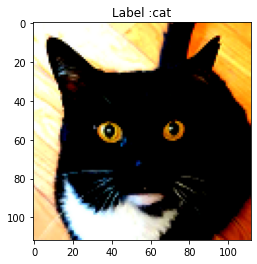

In [68]:
#Visualising data samples from train and test dataset
for i in range(232,233):
    image,label = train_dataset[i]
    plt.imshow(image.permute(1,2,0)) # 0th dimension should come last and 1st and 2nd dimension should come first
    plt.title("Label :{}".format(train_dataset.classes[label]))
    plt.show()

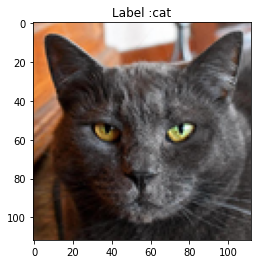

In [69]:
#Visualising data samples from train and test dataset
for i in range(23,24):
    image,label = valid_dataset[i]
    plt.imshow(image.permute(1,2,0)) # 0th dimension should come last and 1st and 2nd dimension should come first
    plt.title("Label :{}".format(valid_dataset.classes[label]))
    plt.show()

In [70]:

#creating dataloader
batch_size =128
train_loader = DataLoader(train_dataset,batch_size,shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size,shuffle=True,  num_workers=4, pin_memory=True)

In [71]:
for batch in train_loader:
  print(batch[0])
  break

tensor([[[[-0.5765, -0.5373, -0.5137,  ..., -0.3020, -0.3098, -0.3255],
          [-0.5608, -0.5216, -0.4980,  ..., -0.2000, -0.2706, -0.3412],
          [-0.5373, -0.5137, -0.4902,  ..., -0.2157, -0.1843, -0.1451],
          ...,
          [ 0.2863,  0.3020,  0.3176,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.2706,  0.2863,  0.3098,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.2471,  0.2314,  0.2941,  ...,  1.0000,  1.0000,  1.0000]],

         [[-0.5294, -0.4980, -0.4667,  ..., -0.3176, -0.3255, -0.3412],
          [-0.5059, -0.4824, -0.4588,  ..., -0.2157, -0.2941, -0.3569],
          [-0.4980, -0.4745, -0.4510,  ..., -0.2392, -0.2000, -0.1686],
          ...,
          [ 0.3804,  0.4118,  0.4431,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.3804,  0.4118,  0.4510,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.3647,  0.3725,  0.4510,  ...,  1.0000,  1.0000,  1.0000]],

         [[-0.8353, -0.7961, -0.7725,  ..., -0.4039, -0.4039, -0.4275],
          [-0.8196, -0.7804, -

In [72]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [73]:
device

device(type='cuda')

#### 1. Forward Process i.e Noise Scheduler.

---



In [84]:
def linear_scheduler(time_steps, start=1e-5,end=1e-2):
  return torch.linspace(start,end,time_steps)

def get_index_from_list(values,t,x_shape):
  batch_size= t.shape[0]
  out = values.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,)* (len(x_shape)-1))).to(t.device)

#forward diffusion sample
# takes an image and a timestep as input and yields the noise corrupted image

def forward_diffusion_sample(x_0, t, device):
  noise = torch.randn_like(x_0)
  sqrt_alphas_product_t = get_index_from_list(sqrt_alpha_product,t, x_0.shape)
  sqrt_one_minus_alpha_product_t = get_index_from_list(sqrt_one_minus_alpha_product, t,x_0.shape)

  # mean and variance

  return sqrt_alphas_product_t.to(device) * x_0.to(device) + sqrt_one_minus_alpha_product_t.to(device) * noise.to(device), noise.to(device)

In [85]:
# defining schedule
T = 1000
betas = linear_scheduler(time_steps=T)

# calculating terms
alphas= 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0/alphas)
sqrt_alpha_product = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alpha_product = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev)/ (1. - alphas_cumprod)

In [98]:
# util function to display image
def display_tensor(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()])
    #extract 0th image from batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))


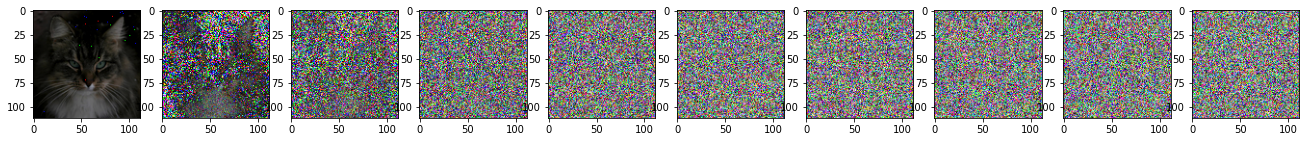

In [99]:
#simulating forward diffusion
images  = [train_dataset.__getitem__(0)][0][0]
plt.figure(figsize= (25,25))
num_images = 10
stepsize= int(T/num_images)

for idx in range(0,T,stepsize):
  t = torch.Tensor([idx]).type(torch.int64)
  plt.subplot(1,num_images+1, int(idx/stepsize)+1)
  image,noise = forward_diffusion_sample(images,t,device="cpu")
  display_tensor(image)

#### 2. Backward Process i.e UNet.

---



In [100]:
class Block(nn.Module):
  def __init__(self, input_channels, output_channels, time_embed_dim, up_conv=False):
    super().__init__()
    self.time_mlp = nn.Linear(time_embed_dim,output_channels) # similar to transformers, getting the embedding dimension
    if up_conv:
      self.conv1 = nn.Conv2d(2* input_channels, output_channels, 3, padding=1)
      self.transform = nn.ConvTranspose2d(output_channels, output_channels,4,2,1)

    else:
      self.conv1= nn.Conv2d(input_channels, output_channels,3,padding=1)
      self.transform = nn.Conv2d(output_channels, output_channels,4,2,1)

    self.conv2 = nn.Conv2d(output_channels, output_channels,3,padding=1)
    self.batch_norm1 = nn.BatchNorm2d(output_channels)
    self.batch_norm2 = nn.BatchNorm2d(output_channels)
    self.relu = nn.ReLU()

  
  def forward(self,x,t):
    # first conv
    out = self.batch_norm1(self.relu(self.conv1(x)))
    #time embedding
    time_embedding = self.relu(self.time_mlp(t))
    # extending last two dimensions
    time_embedding = time_embedding[(...,)+ (None,)*2]
    # adding time channel
    out = out + time_embedding
    #second conv
    out = self.batch_norm2(self.relu(self.conv2(out)))
    #downsample or upsample as per flags
    return self.transform(out)


In [101]:
# sinusoidal positional embeddings
class PosEmbed(nn.Module):
  def __init__(self,dim):
    super().__init__()
    self.dim = dim

  def forward(self,time_step_tensors):
    device= time_step_tensors.device
    # half to be multipllied by sin and cos
    half_dim = self.dim//2
    embeddings = math.log(10000)/(half_dim-1)
    embeddings = torch.exp(torch.arange(half_dim, device=device)* -embeddings)
    embeddings = time_step_tensors[:,None] * embeddings[None,:]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings

In [102]:
class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    image_channels = 3
    down_channels = (64,128,256,512,1024)
    up_channels =(1024,512,256,128,64)
    output_dimension= 1
    time_embed_dim = 32

    self.time_mlp = nn.Sequential(
        PosEmbed(time_embed_dim),
        nn.Linear(time_embed_dim, time_embed_dim),
        nn.ReLU()
    )

    self.conv0 = nn.Conv2d(image_channels, down_channels[0],3, padding=1)

    # downsample
    self.down_sampled = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_embed_dim) for i in range(len(down_channels)-1)])

    #upsampled
    self.up_sampled = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_embed_dim,up_conv=True) for i in range(len(up_channels)-1)])

    self.output = nn.Conv2d(up_channels[-1],3,output_dimension)

  
  def forward(self,x,time_step):
    #embedding time
    t = self.time_mlp(time_step)
    #first conv
    x = self.conv0(x)
    # unet
    residual_inputs= []
    for down in self.down_sampled:
      x = down(x,t)
      residual_inputs.append(x)
    
    for up in self.up_sampled:
      residual_x = residual_inputs.pop()
      # add residual x as add. channels
      #print(residual_x.shape)

      x = torch.cat((x,residual_x), dim=1)
      x = up(x,t)

    return self.output(x)


In [103]:
model = Unet()

In [104]:
model

Unet(
  (time_mlp): Sequential(
    (0): PosEmbed()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_sampled): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2

In [105]:
model = model.to(device)

# 3. Loss function

L2 distance between actual noise and predicted noise.

In [106]:
def loss_function(model,x_0,t):
  x_noisy, noise = forward_diffusion_sample(x_0, t, device="cuda")
  noise_pred = model(x_noisy,t)
  return F.l1_loss(noise,noise_pred)

## 4. Sampling

In [107]:
# adding torch.no_grad so that prev gradients for images are not stored for calculation
@torch.no_grad()
def sample_timestep(x,t):
  betas_t = get_index_from_list(betas,t,x.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alpha_product,t,x.shape)
  sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas,t,x.shape)

  # generating model mean
  model_mean = sqrt_recip_alphas_t * (x- betas_t * model(x,t)/ sqrt_one_minus_alphas_cumprod_t)

  posterior_variance_t = get_index_from_list(posterior_variance,t, x.shape)

  if t ==0:
    return model_mean

  else:
    noise = torch.randn_like(x)
    return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def display_sample_image():
  #sample noise
  img_size = 64
  img = torch.randn((1,3,img_size, img_size), device=device)
  plt.figure(figsize=(25,25))
  num_images = 10
  step_size = int(T/num_images)

  for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            display_tensor(img.detach().cpu())
  plt.show()

Epoch - 0, Step - 0, Loss - 0.8111177086830139


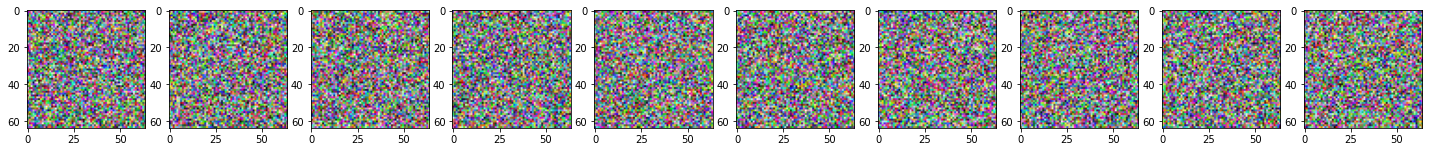

Epoch - 0, Step - 1, Loss - 0.8005589842796326


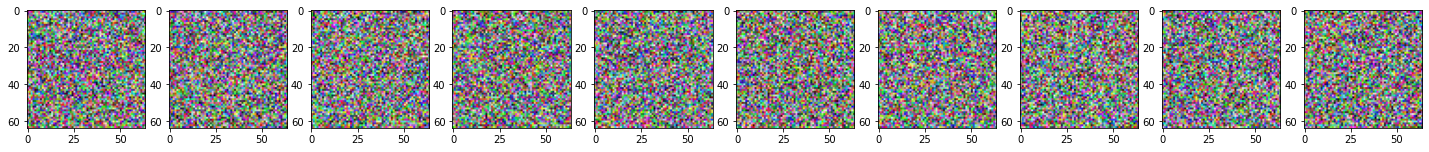

Epoch - 0, Step - 2, Loss - 0.7918621897697449


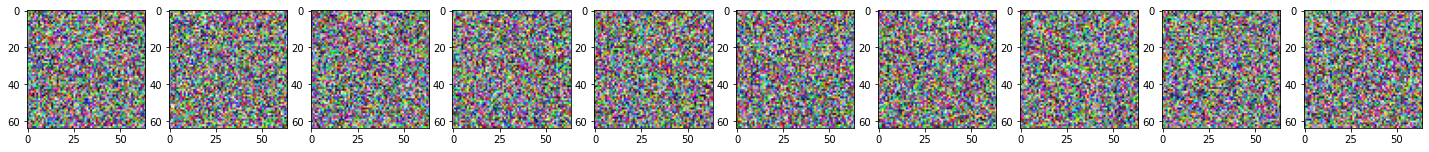

Epoch - 0, Step - 3, Loss - 0.7821800112724304


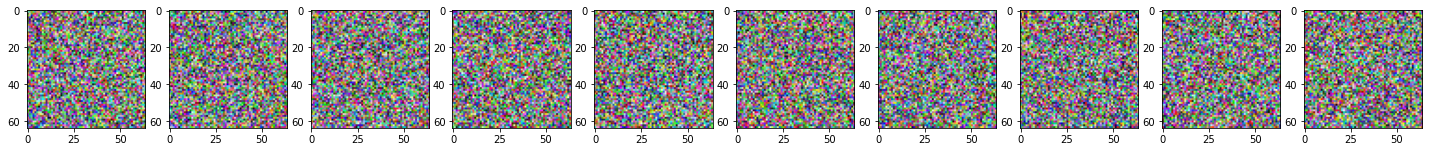

Epoch - 0, Step - 4, Loss - 0.7730046510696411


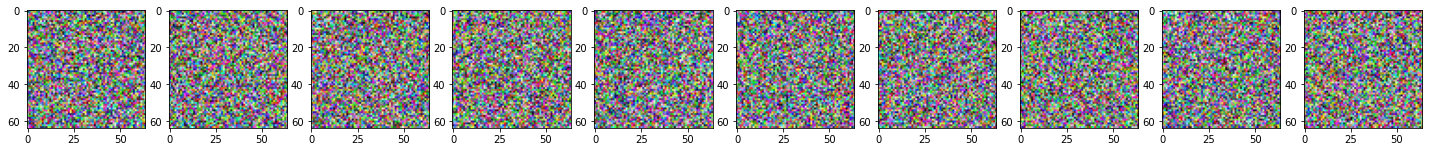

Epoch - 0, Step - 5, Loss - 0.7658957839012146


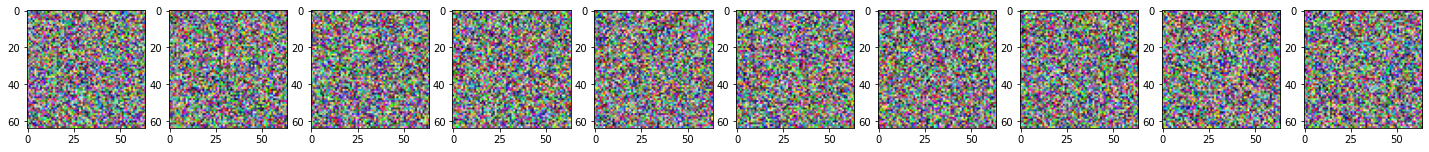

Epoch - 0, Step - 6, Loss - 0.7569214701652527


In [ ]:
# Training model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5000

for epoch in range(epochs):
  for step,batch in enumerate(train_loader):
    optimizer.zero_grad()
    t = torch.randint(0,T,(batch_size,), device = device).long() # 128 - batch size
    loss = loss_function(model,batch[0],t)
    loss.backward()
    optimizer.step()

    if epoch %10==0:
      print("Epoch - {}, Step - {}, Loss - {}".format(epoch,step,loss.item()))
      display_sample_image()